# SETUP


In [1]:
%%capture
!pip install xarray
!pip install wandb
!pip install collections
!pip install pysteps
!pip install beartype
!pip install scikit-image
!pip install netcdf4

In [2]:
import os
new_directory = '/dss/dsshome1/0D/ge74xuf2/climate_diffusion'
os.chdir(new_directory)
os.getcwd()

'/dss/dsshome1/0D/ge74xuf2/climate_diffusion'

In [3]:
from torch.utils.data import DataLoader, Subset

In [4]:
import math
import copy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import xarray as xr
import wandb
import IPython.display as display
import logging
import torch.nn.functional as F
import collections
import copy
import torchvision.transforms as transforms


from PIL import Image
from torch import optim
from PIL import Image
from torch.utils import data
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split
from inspect import isfunction
from functools import partial
from abc import abstractmethod
from skimage.metrics import structural_similarity as ssim
from pysteps.utils.spectral import rapsd, corrcoef
import matplotlib.ticker as ticker

from src.utils import *
from src.utils_essential import *
from src.base_network import BaseNetwork
from src.imagen_unet import *
from src.helper import *
from tqdm import tqdm


from src.dataloader_sr import gfdl_eval_256, era5_upscaled_1d_256, era5_0_25d_256, qm_gfdl_trafo_units_hr
from src.dataloader_sr import QM_GFDL_LR_Dataset_256

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
config = {"run_name": "revision_100",     
          "epochs":        400,
          "batch_size":    2, 
          "lr":            1e-5, 
          "image_size":    256,             
          "device":        "cuda", 
          "num_workers":   8, 
}

wandb.init(project='climate-diffusion', entity='Michi',config=config, save_code=True)
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michi. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


# Dataloaders 

In [6]:
era5_hr_ds = era5_0_25d_256(stage='train')
era5_hr_dl = data.DataLoader(era5_hr_ds, batch_size=wandb.config.batch_size, shuffle=False, drop_last=True,
                                     num_workers=wandb.config.num_workers)
sample_era5_025_tr = next(iter(era5_hr_dl))
print("HR ERA5", sample_era5_025_tr.shape)

HR ERA5 torch.Size([2, 1, 256, 256])


In [7]:
era5_lr_ds = era5_upscaled_1d_256(stage='train')
era5_lr_dl = data.DataLoader(era5_lr_ds, batch_size=wandb.config.batch_size, shuffle=False, drop_last=True,
                                     num_workers=wandb.config.num_workers)

sample_era5_1d_256p = next(iter(era5_lr_dl))
print("LR ERA5", sample_era5_1d_256p.shape)

LR ERA5 torch.Size([2, 1, 256, 256])


## validation DL

In [8]:
bs_valid = 2

eval_true = True

In [9]:
if eval_true == True:
    era5_p_1d_256_v = era5_upscaled_1d_256(stage='valid')

    dataloader_era5_val_1d_256 = data.DataLoader(era5_p_1d_256_v, batch_size=bs_valid, shuffle=False, drop_last=True,
                                         num_workers=wandb.config.num_workers)

    era5_lr_v = next(iter(dataloader_era5_val_1d_256))
    print(era5_lr_v.shape)

if eval_true == True:
    era5_p025 = era5_0_25d_256(stage='valid')
    dataloader_era5_val_p025 = data.DataLoader(era5_p025, batch_size=bs_valid, shuffle=False, drop_last=True,
                                         num_workers=wandb.config.num_workers)

    era5_hr_v = next(iter(dataloader_era5_val_p025))
    print(era5_hr_v.shape)

torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])


In [10]:
#  qm-us inference QM-corrected gfdl
if eval_true == True:

    bc_gfdl_dataset_val = QM_GFDL_LR_Dataset_256('data/11_01_deltaQM_debiased_gfdl_valid_custom_dl.pth')

    dataloader_bc_gfdl_val = data.DataLoader(bc_gfdl_dataset_val, batch_size=bs_valid, shuffle=False,
                                      drop_last=True,num_workers=2)


    bc_gfld_sample = next(iter(dataloader_bc_gfdl_val))
    print("QM+US - GFDL LR 256 shape:",bc_gfld_sample.shape)

/dss/dsshome1/0D/ge74xuf2/climate_diffusion/src/dataloader_sr.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.era5_qm = torch.load(self.path).cpu().numpy()


datasets size torch.Size([1400, 64, 64])
QM+US - GFDL LR 256 shape: torch.Size([2, 1, 256, 256])


In [11]:
dl_1y_era5_lr = data.DataLoader(era5_p_1d_256_v, batch_size=10, shuffle=False, drop_last=True,
                                     num_workers=wandb.config.num_workers)

era5_lr_1y = next(iter(dl_1y_era5_lr))
print(era5_lr_1y.shape)

torch.Size([10, 1, 256, 256])


In [12]:
do_generate_ensemble_5d_s50 = False

if do_generate_ensemble_5d_s50==True:
    
    import torch
    from torch.utils.data import DataLoader, Subset
    
    # Define the subset of the dataset (first 365 days)
    era5_p_1d_256_v_subset = Subset(era5_p_1d_256_v, range(365))
    
    # Define the DataLoader with the subset and batch size of 5
    dl_365d_era5_lr = DataLoader(era5_p_1d_256_v_subset, batch_size=5, shuffle=False, drop_last=True, num_workers=wandb.config.num_workers)
    
    # Load the diffusion model
    m_path = "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_100/100_Imagen.pth"   
    dm_loaded = palette_model.load_pretrain_diffusion(m_path)
    
    do_save_sr_dataset_era5 = True
    # Apply the diffusion model and save the results
    if do_save_sr_dataset_era5:
        output_tensors = []
    
        for b, el in enumerate(dl_365d_era5_lr):
            if b % 5 == 0:
                print(f"Processing batch {b+1}...")
            # Move input batch to CUDA
            el,_ ,_ ,_  = imagen.noise_schedulers.q_sample(el.to("cpu"),torch.tensor(50))
            el = torch.clip(el,-1,1)
            era5_lr_batch = el.to("cuda").float()
            
            
            # Apply the diffusion model to restore the data
            sr_era5_output = dm_loaded.restoration(start_image_or_video=era5_lr_batch)
            output_tensors.append(sr_era5_output.to("cpu"))
    
        # Concatenate all output tensors into one dataset
        sr_era5_dataset = torch.cat(output_tensors, dim=0)
        
        print(f"Super-resolved dataset shape: {sr_era5_dataset.shape}")


In [13]:
if do_generate_ensemble_5d_s50==True:
    # Step 1: Compute mean over spatial dimensions (256x256) for ERA5 reference
    era5_daily_mean = era5_reference.view(5, -1).mean(dim=1).cpu().numpy()  # Mean over spatial dims for each day
    
    # Step 2: Compute the ensemble mean (across 50 runs) for each day
    ensemble_daily_mean = ensemble_stack.mean(dim=0).view(5, -1).mean(dim=1).cpu().numpy()  # Mean over 50 ensemble runs and spatial dims
    
    # Step 3: Calculate the min and max for the spread (min-max range for each day)
    ensemble_daily_min = ensemble_stack.min(dim=0)[0].view(5, -1).mean(dim=1).cpu().numpy()  # Min over ensemble runs and spatial dims
    ensemble_daily_max = ensemble_stack.max(dim=0)[0].view(5, -1).mean(dim=1).cpu().numpy()  # Max over ensemble runs and spatial dims
    
    # Step 4: Plot the ERA5 reference mean and ensemble mean with the min-max spread
    
    days_range = np.arange(1, 6)  # Days of the year (5 days in this case)
    
    plt.figure(figsize=(12, 6))
    
    # Plot ERA5 mean (blue line)
    plt.plot(days_range, era5_daily_mean, color='blue', label='ERA5 Mean')
    
    # Plot Ensemble mean (red line)
    plt.plot(days_range, ensemble_daily_mean, color='red', label='DM Ensemble Mean')
    
    # Fill the area between the ensemble min and max (red shaded area)
    plt.fill_between(
        days_range,
        ensemble_daily_min,
        ensemble_daily_max,
        color='red',
        alpha=0.3,
        label='DM Ensemble Spread (Min-Max)'
    )
    
    # Add labels and legend
    plt.title("Comparison of Ensemble and ERA5 Mean with Spread (Min-Max)")
    plt.xlabel("Days of the Year")
    plt.ylabel("Mean Precipitation in mm/d")
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()


In [14]:
#torch.save(sr_era5_dataset, os.path.join("/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble", "365d_100_1.pt"))

In [15]:
#x = torch.load("/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble/365d_100_1.pt", weights_only=True)

In [16]:
#era5_comparison = next(iter(DataLoader(era5_p_1d_256_v_subset, batch_size=365, shuffle=False, drop_last=True)))
#plt.plot(np.arange(365), sr_era5_dataset.squeeze(1).mean(dim=(1,2)), color='purple')
#plt.plot(np.arange(365), era5_comparison.squeeze(1).mean(dim=(1,2)), color='orange')
#plt.title("1 year time series ERA5 vs ensemble DM - ERA5")
#plt.show()

In [17]:
do_generate_ensemble_1y_s50 = False

if do_generate_ensemble_1y_s50==True:
    from torch.utils.data import DataLoader, Subset
    
    # Define the subset of the dataset (first 365 days)
    era5_p_1d_256_v_subset = Subset(era5_p_1d_256_v, range(365))
    
    # Define the DataLoader with the subset and batch size of 5
    dl_365d_era5_lr = DataLoader(era5_p_1d_256_v_subset, batch_size=5, shuffle=False, drop_last=True, num_workers=wandb.config.num_workers)
    
    # Load the diffusion model
    m_path = "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_100/100_Imagen.pth"   
    dm_loaded = palette_model.load_pretrain_diffusion(m_path)
    
    # Folder to save ensemble results
    save_folder = "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble"
    os.makedirs(save_folder, exist_ok=True)
    
    # Perform 50 ensemble runs
    ensemble_outputs = []  # Store all ensemble outputs for spread comparison
    for i in range(1, 51):
        print(f"Starting ensemble run {i}...")
        output_tensors = []
    
        for b, el in enumerate(dl_365d_era5_lr):
            print(f"  Processing batch {b+1}...")
            # Move input batch to CUDA
            el,_ ,_ ,_  = imagen.noise_schedulers.q_sample(el.to("cpu"),torch.tensor(50))
            el = torch.clip(el,-1,1)
            era5_lr_batch = el.to("cuda").float()
            
            # Apply the diffusion model to restore the data
            sr_era5_output = dm_loaded.restoration(start_image_or_video=era5_lr_batch)
            output_tensors.append(sr_era5_output)
    
        # Concatenate all output tensors into one dataset
        sr_era5_dataset = torch.cat(output_tensors, dim=0)
        ensemble_outputs.append(sr_era5_dataset)  # Add this to the ensemble list
        
        # Save the current ensemble output
        save_path = os.path.join(save_folder, f"ensemble_{i}.pt")
        torch.save(sr_era5_dataset, save_path)
        print(f"  Saved ensemble run {i} to {save_path}")
    
    print("All ensemble runs completed. Now calculating spread...")

# load data

In [18]:
save_folder = "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble"

# Initialize a list to store the loaded ensemble runs
ensemble_outputs2 = []

# Load all ensemble runs from the folder
for i in range(1, 51):  # Assuming you have 50 ensemble runs saved as ensemble_1.pt, ensemble_2.pt, ...
    file_path = os.path.join(save_folder, f"ensemble_{i}.pt")
    
    if os.path.exists(file_path):
        print(f"Loading {file_path}...")
        ensemble_run = torch.load(file_path, weights_only=True)  # Load the saved tensor
        print("trafo units here")
        ensemble_run = era5_hr_ds.inverse_dwd_trafo(ensemble_run)
        ensemble_outputs2.append(ensemble_run)
    else:
        print(f"File {file_path} does not exist.")

# After loading all ensemble runs, stack them along a new dimension (dim=0)
dm_ensemble_stack = torch.stack(ensemble_outputs2, dim=0).detach().cpu()  # Shape: (50, 365*256*256 or so, ...)

# Now you can proceed with the further analysis or visualization
print(f"DM Ensemble stack shape: {dm_ensemble_stack.shape}")

Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble/ensemble_1.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble/ensemble_2.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble/ensemble_3.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble/ensemble_4.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble/ensemble_5.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble/ensemble_6.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ensemble/ensemble_7.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_ens

In [19]:
save_folder = "/dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble"

# Initialize a list to store the loaded ensemble runs
ensemble_outputs2 = []

# Get all files matching the pattern "ensemble_*.pt" and sort them numerically
file_names = [f for f in os.listdir(save_folder) if f.startswith("ensemble_") and f.endswith(".pt")]
file_names_sorted = sorted(file_names, key=lambda x: int(x.split('_')[1].split('.')[0]))

# Load all ensemble runs from the sorted file names
for file_name in file_names_sorted:
    file_path = os.path.join(save_folder, file_name)
    
    if os.path.exists(file_path):
        print(f"Loading {file_path}...")
        ensemble_run = torch.load(file_path, weights_only=True).cpu()  # Load the saved tensor
        print("trafo units here")
        ensemble_run = era5_hr_ds.inverse_dwd_trafo(ensemble_run)
        ensemble_outputs2.append(ensemble_run)
    else:
        print(f"File {file_path} does not exist.")

# After loading all ensemble runs, stack them along a new dimension (dim=0)
vqvae_ensemble_stack = torch.stack(ensemble_outputs2, dim=0).detach().cpu() # Shape: (number_of_files, ...)
print(f"VQVAE Ensemble stack shape: {vqvae_ensemble_stack.shape}")

Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble/ensemble_1.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble/ensemble_2.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble/ensemble_3.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble/ensemble_4.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble/ensemble_5.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble/ensemble_6.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/pn49fu-dss-0002/ge74xuf2/diffusion/revision_2_vq_vae_ensemble/ensemble_7.pt...
trafo units here
Loading /dss/dssfs04/lwp-dss-0002/pn49fu/

In [20]:
"""
era5_p_1d_256_v = era5_upscaled_1d_256(stage='valid')
era5_p_1d_256_v_subset = Subset(era5_p_1d_256_v, range(365))
era5_reference = next(iter(DataLoader(era5_p_1d_256_v_subset, batch_size=365, shuffle=False, drop_last=True)))
era5_lr_reference = era5_p_1d_256_v.inverse_dwd_trafo(era5_reference)
print("era5 lr reference",era5_lr_reference.shape)
"""

era5_p025 = era5_0_25d_256(stage='valid')
era5_p_1d_256_v_subset = Subset(era5_p025, range(365))
dataloader_era5_val_p025 = data.DataLoader(era5_p025, batch_size=365, shuffle=False, drop_last=True)
era5_hr_reference = next(iter(dataloader_era5_val_p025))
era5_hr_reference = era5_p025.inverse_dwd_trafo(era5_hr_reference)
print("era5_hr_reference", era5_hr_reference.shape)


dm_ensemble_mean = dm_ensemble_stack.mean(dim=0)
print("dm ensemble_stack",dm_ensemble_stack.shape)
print("dm ensemble_mean",dm_ensemble_mean.shape)


vqvae_ensemble_mean = vqvae_ensemble_stack.mean(dim=0)
print("vqvae ensemble_stack",vqvae_ensemble_stack.shape)
print("vqvae ensemble_mean",vqvae_ensemble_mean.shape)

era5_hr_reference torch.Size([365, 1, 256, 256])
dm ensemble_stack torch.Size([50, 365, 1, 256, 256])
dm ensemble_mean torch.Size([365, 1, 256, 256])
vqvae ensemble_stack torch.Size([50, 365, 1, 256, 256])
vqvae ensemble_mean torch.Size([365, 1, 256, 256])


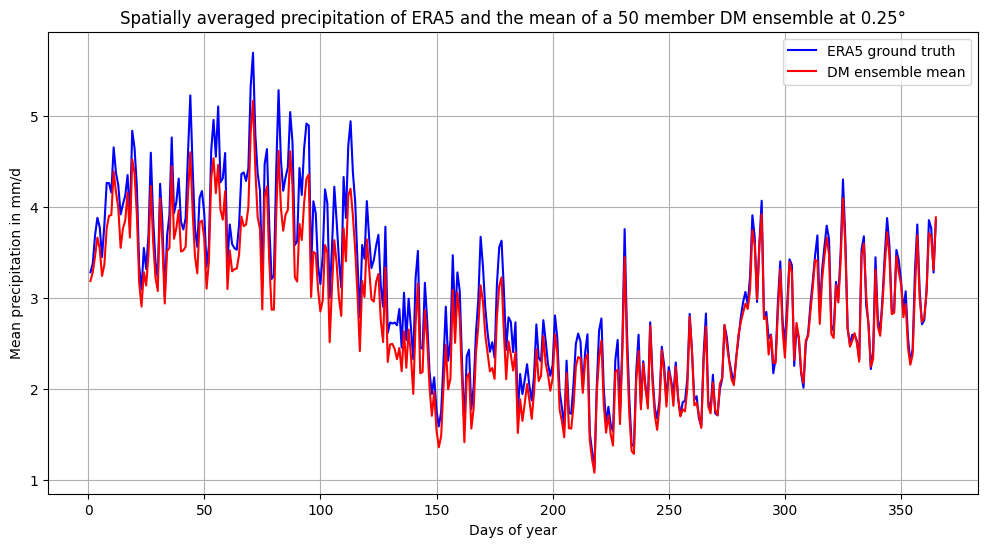

In [22]:
days_plot = 365

era5_daily_mean = era5_hr_reference.view(days_plot, -1).mean(dim=1).cpu().numpy()  # Mean over spatial dims for each day

dm_ensemble_daily_mean = dm_ensemble_stack.mean(dim=0).view(days_plot, -1).mean(dim=1).cpu().numpy()  # Mean over 50 ensemble runs and spatial dims



days_range = np.arange(1, days_plot +1 )  # Days of the year (5 days in this case)

plt.figure(figsize=(12, 6))

plt.plot(days_range, era5_daily_mean, color='blue', label='ERA5 ground truth')
plt.plot(days_range, dm_ensemble_daily_mean, color='red', label='DM ensemble mean')

plt.title("Spatially averaged precipitation of ERA5 and the mean of a 50 member DM ensemble at 0.25°")
plt.xlabel("Days of year")
plt.ylabel("Mean precipitation in mm/d")
plt.legend()
plt.grid(True)
plt.savefig('figures_paper/ensemble_mean_temporal.pdf', dpi=300)
plt.show()

# do spread ERA5 ds vs spread DM ds 

In [23]:
era5_p025 = era5_0_25d_256(stage='valid')
era5_p_1d_256_v_subset = Subset(era5_p025, range(365))
dataloader_era5_val_p025 = data.DataLoader(era5_p025, batch_size=365, shuffle=False, drop_last=True)
era5_hr_reference = next(iter(dataloader_era5_val_p025))
era5_hr_reference = era5_p025.inverse_dwd_trafo(era5_hr_reference)
print("era5_hr_reference", era5_hr_reference.shape)

dm_ensemble_mean = dm_ensemble_stack.mean(dim=0)
print("dm ensemble_stack",dm_ensemble_stack.shape)
print("dm ensemble_mean",dm_ensemble_mean.shape)


vqvae_ensemble_mean = vqvae_ensemble_stack.mean(dim=0)
print("vqvae ensemble_stack",vqvae_ensemble_stack.shape)
print("vqvae ensemble_mean",vqvae_ensemble_mean.shape)

era5_hr_reference torch.Size([365, 1, 256, 256])
dm ensemble_stack torch.Size([50, 365, 1, 256, 256])
dm ensemble_mean torch.Size([365, 1, 256, 256])
vqvae ensemble_stack torch.Size([50, 365, 1, 256, 256])
vqvae ensemble_mean torch.Size([365, 1, 256, 256])


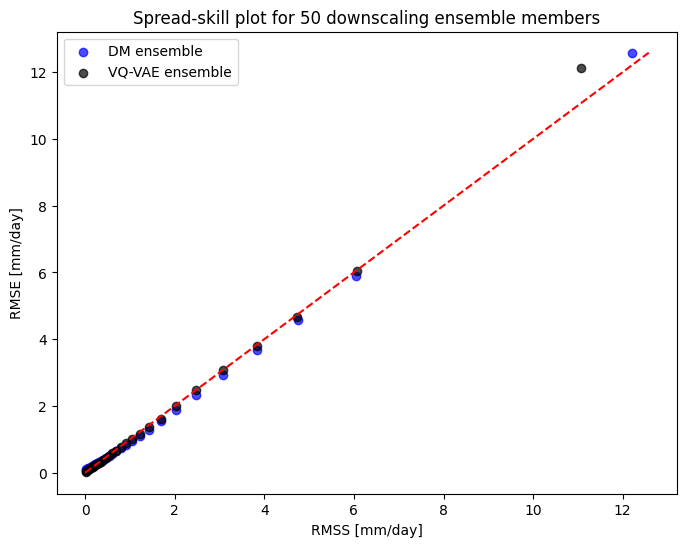

In [24]:
# Compute ensemble mean across ensemble members
dm_ensemble_mean = dm_ensemble_stack.mean(dim=0)  # Shape: [365, 1, 256, 256]

# Compute squared spread and squared error for each grid box
squared_spread = torch.mean((dm_ensemble_stack - dm_ensemble_mean.unsqueeze(0)) ** 2, dim=0)  # Squared spread
squared_error = (dm_ensemble_mean - era5_hr_reference) ** 2  # Squared error

# Flatten across time and space
squared_spread_flat = squared_spread.flatten(start_dim=1).flatten()
squared_error_flat = squared_error.flatten(start_dim=1).flatten()

# Define bin boundaries based on percentiles
percentiles = np.linspace(0, 100, 31)  # 5%, 10%, ..., 95%
bin_boundaries = np.percentile(squared_spread_flat.cpu().numpy(), percentiles)
bin_boundaries[0] -= 1e-6  # Include all values

# Initialize arrays for binned RMSS and RMSE
binned_rmss_1 = []
binned_rmse_1 = []

for i in range(len(bin_boundaries) - 1):
    bin_mask = (squared_spread_flat >= bin_boundaries[i]) & (squared_spread_flat < bin_boundaries[i + 1])
    bin_squared_spread = squared_spread_flat[bin_mask]
    bin_squared_error = squared_error_flat[bin_mask]
    
    if len(bin_squared_spread) > 0:
        binned_rmss_1.append(torch.sqrt(bin_squared_spread.mean()).item())
        binned_rmse_1.append(torch.sqrt(bin_squared_error.mean()).item())

# Repeat the process for the second calculation
vqvae_ensemble_mean = vqvae_ensemble_stack.mean(dim=0)  # Shape: [365, 1, 256, 256]
squared_spread_2 = torch.mean((vqvae_ensemble_stack - vqvae_ensemble_mean.unsqueeze(0)) ** 2, dim=0)
squared_error_2 = (vqvae_ensemble_mean - era5_hr_reference) ** 2

squared_spread_flat_2 = squared_spread_2.flatten(start_dim=1).flatten()
squared_error_flat_2 = squared_error_2.flatten(start_dim=1).flatten()

binned_rmss_2 = []
binned_rmse_2 = []

for i in range(len(bin_boundaries) - 1):
    bin_mask = (squared_spread_flat_2 >= bin_boundaries[i]) & (squared_spread_flat_2 < bin_boundaries[i + 1])
    bin_squared_spread = squared_spread_flat_2[bin_mask]
    bin_squared_error = squared_error_flat_2[bin_mask]
    
    if len(bin_squared_spread) > 0:
        binned_rmss_2.append(torch.sqrt(bin_squared_spread.mean()).item())
        binned_rmse_2.append(torch.sqrt(bin_squared_error.mean()).item())

# Combined Plot
plt.figure(figsize=(8, 6))
plt.scatter(binned_rmss_1, binned_rmse_1, color='blue', label='DM ensemble', alpha=0.7)
plt.scatter(binned_rmss_2, binned_rmse_2, color='black', label='VQ-VAE ensemble', alpha=0.7)

# Add reference line
max_val = max(max(binned_rmss_1 + binned_rmse_1), max(binned_rmss_2 + binned_rmse_2))
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')

# Finalize plot
plt.xlabel("RMSS [mm/day]")
plt.ylabel("RMSE [mm/day]")
plt.title("Spread-skill plot for 50 downscaling ensemble members")
plt.legend()
plt.savefig('figures_paper/spread_skill.pdf', dpi=300)
plt.show()